В этом ноутбуке описаны эксперименты с SSA и TSSA, сравнивающие их результаты при реконструкции временных рядов. За данные взято потребление электричества за 2015-2016 год

---

Experiment parametrs

In [1]:
dataset_name = 'german_spot_price.csv'
ssa_window_width = 24 * 7

hankelization_window_width = 24
parafac_rank = 24

---

In [2]:
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_percentage_error as MAPE

from os import listdir, getcwd, chdir, makedirs
from os.path import isfile, join
import os

import IPython.display as display

from time import time

sns.set_style("darkgrid")

In [3]:
import tensorly as tl
import pyts.decomposition as pytsd

In [4]:
data = pd.read_csv(f'data/{dataset_name}')
data.head()

,731582,15.09,11.46,9.58,6.55,4.36,2.09,0.06,0.14,0,...,3.2,3.17,6.09,11.25,13.61,10.57,15.23,11.57,14.81,10.4
0,731583,7.94,4.40,2.05,1.98,2.08,6.08,9.58,15.45,16.63,...,25.03,21.85,26.38,32.28,34.54,31.42,27.66,19.93,23.98,17.14
1,731584,8.84,7.00,3.51,2.06,2.08,7.04,8.85,16.82,21.81,...,18.21,14.58,19.06,25.89,24.07,18.38,16.00,13.21,13.93,10.43
2,731585,15.34,8.04,7.05,6.54,4.88,4.09,2.02,7.05,10.55,...,19.24,18.59,23.19,28.98,33.43,27.76,24.46,20.14,23.88,18.93
3,731586,13.18,8.34,7.54,6.59,6.77,5.51,1.04,2.00,4.54,...,11.20,11.43,17.04,29.39,29.91,25.01,21.97,16.59,24.73,14.86
4,731587,11.26,10.00,7.07,6.32,7.04,7.96,9.95,17.00,8.02,...,16.76,14.03,16.57,22.64,23.24,21.53,19.49,18.81,19.26,16.51


График потребления электричества за год

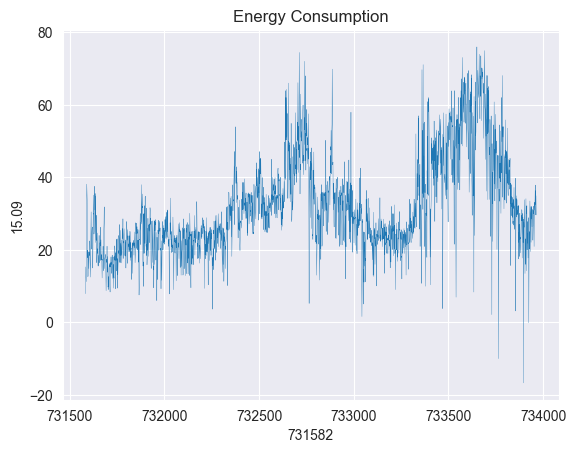

In [5]:
sns.lineplot(data, x='731582', y='15.09', linewidth=0.25)
plt.title('Energy Consumption')
plt.show()

Месяц потребления по неделям

In [6]:
def take_week(data, week_idx):
    idx_from = 24 * 7 * (week_idx - 1)
    idx_to = 24 * 7 * week_idx
    return data[idx_from:idx_to]

In [8]:
# x='731582', y='15.09
t = data['731582'].values
x = data['15.09'].values

In [9]:
window_width = 24

ssa = pytsd.SingularSpectrumAnalysis(window_size=window_width)
ssa_x = ssa.fit_transform(x.reshape(1, -1))

Сумма до первых 10 компонент за год

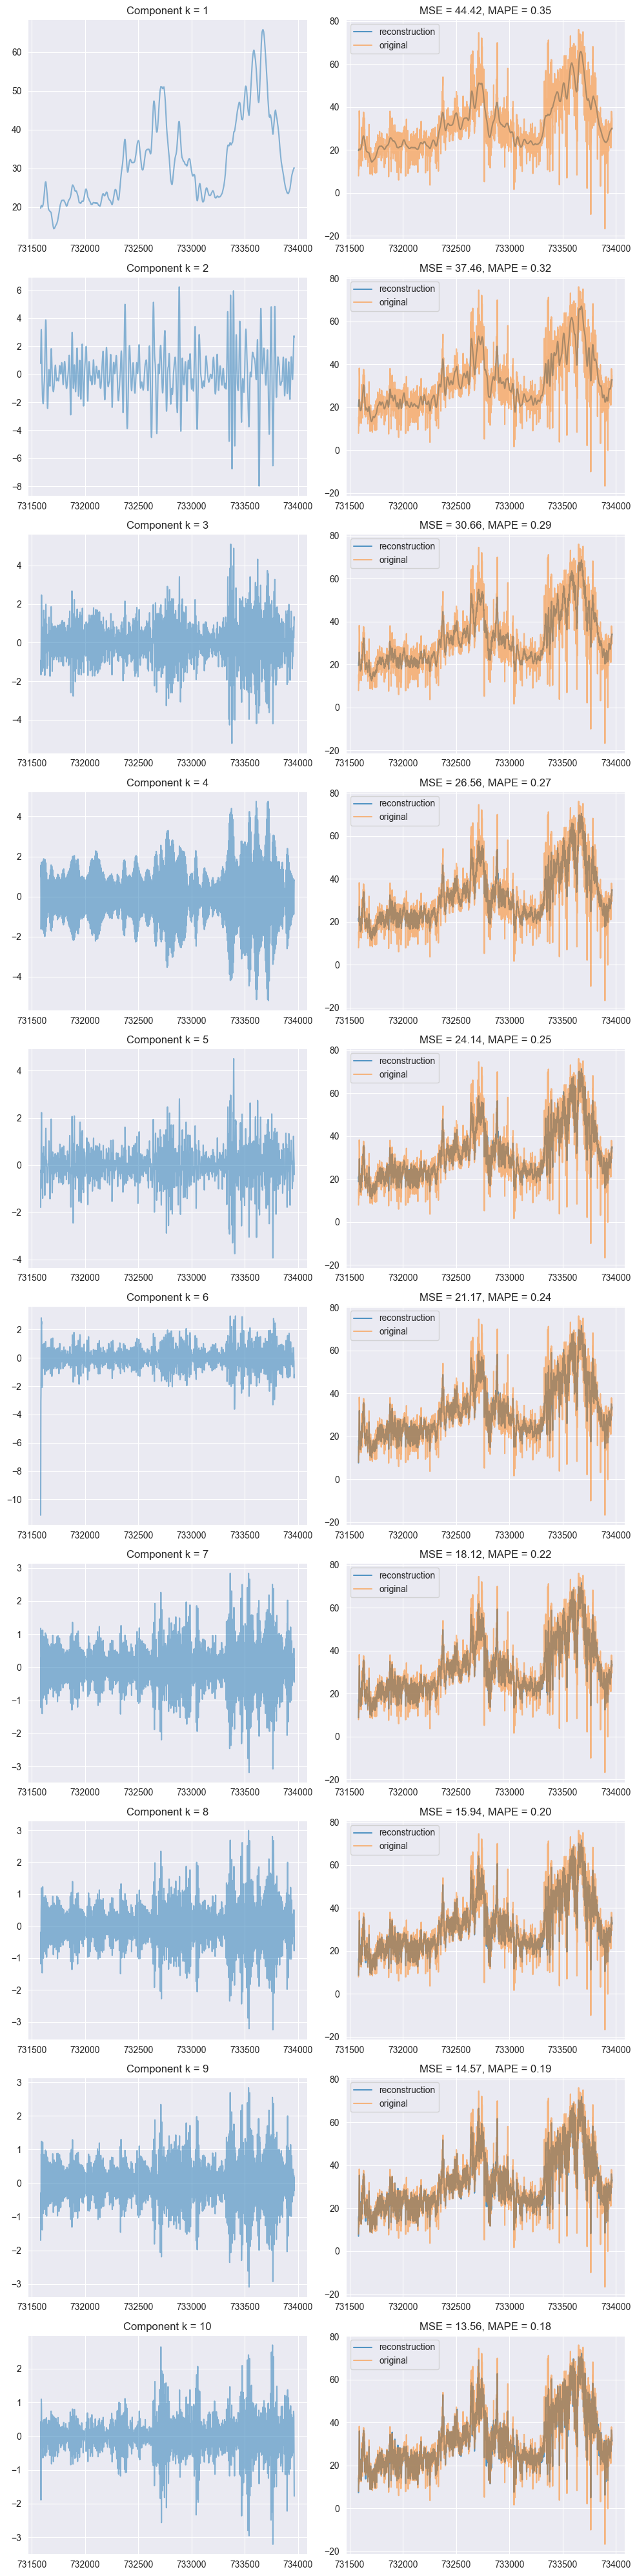

In [10]:
window_take = 10

metrics = {
    'MSE': [],
    'MAPE': []
}

fig = plt.figure(figsize=(10, window_take * 4))
for k in range(0, window_take):
    plt.subplot(window_take, 2, 2 * k + 1)

    kth_component = ssa_x[k]
    plt.plot(t, kth_component, label=f'k = {k+1}', alpha=0.5)
    plt.title(f'Component k = {k+1}')

# ============================================================s

    plt.subplot(window_take, 2, 2 * k + 2)

    first_k_sum = np.sum(ssa_x[:k+1], axis=0)
    plt.plot(t, first_k_sum, label=f'reconstruction', alpha=0.75)
    plt.plot(t, x, label='original', alpha=0.5)
    plt.legend()

    mse = MSE(x, first_k_sum)
    mape = MAPE(x, first_k_sum)

    metrics['MSE'].append(mse)
    metrics['MAPE'].append(mape)

    plt.title(f'MSE = {mse:.2f}, MAPE = {mape:.2f}')


plt.tight_layout()
plt.show()

Сумма до первых 10 компонент за одинадцатую неделю

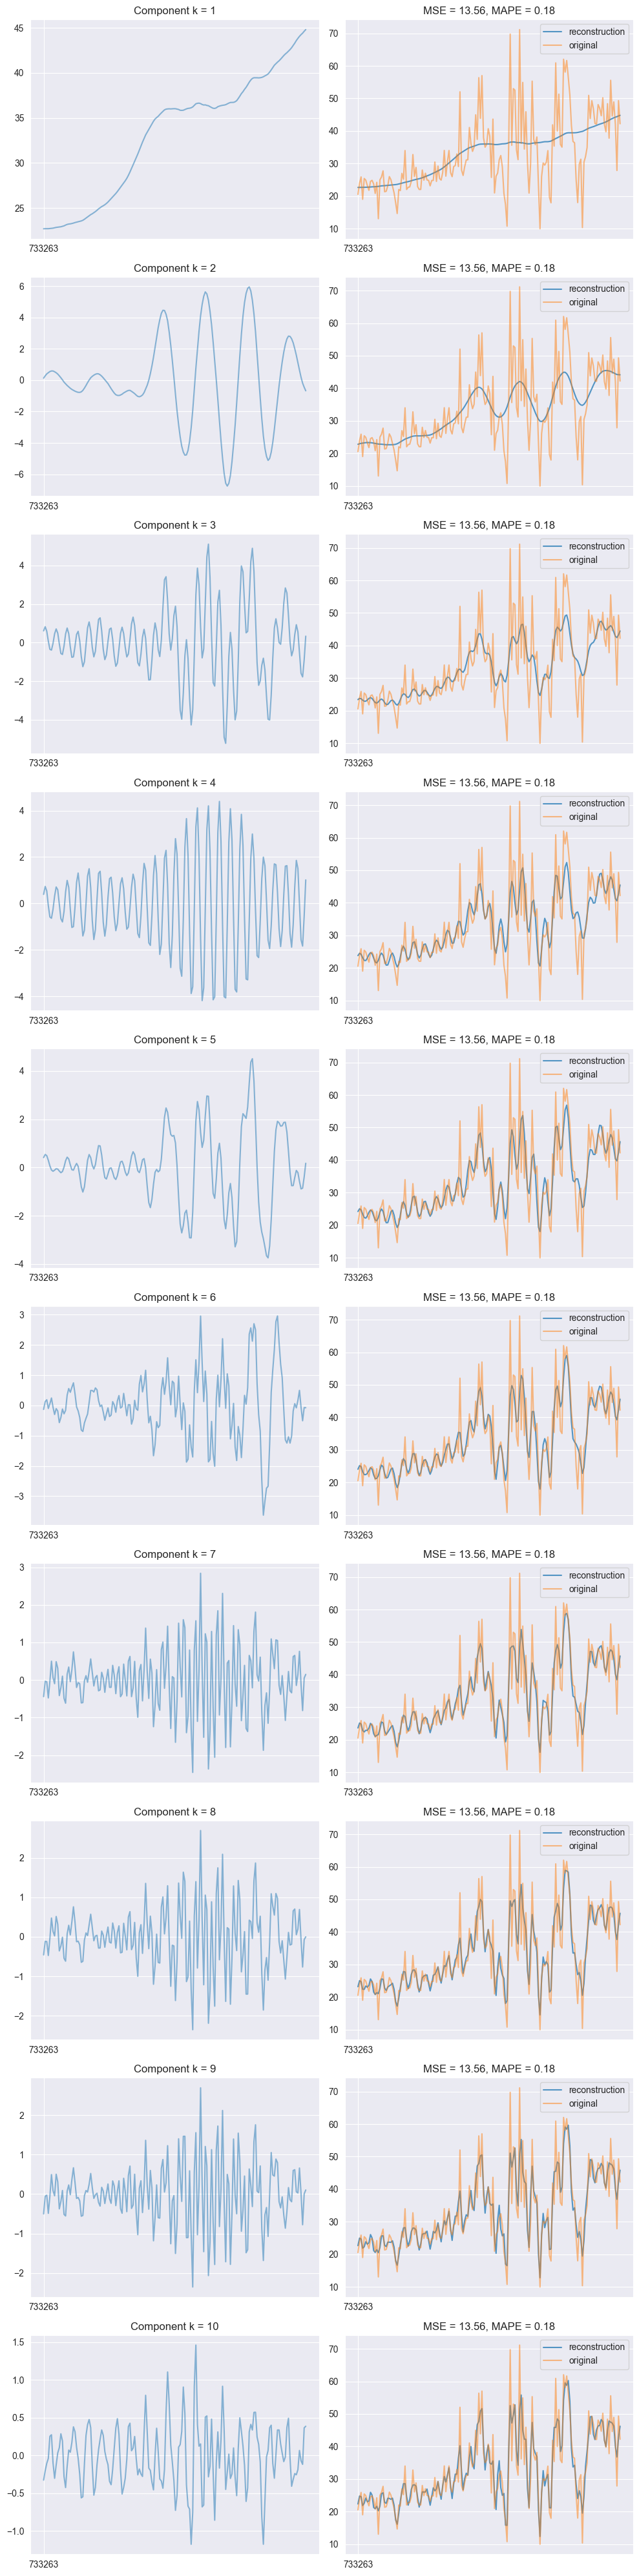

In [11]:
window_take = 10
week_idx = 11

fig = plt.figure(figsize=(10, window_take * 4))
for k in range(0, window_take):
    plt.subplot(window_take, 2, 2 * k + 1)

    week_x = lambda data : take_week(data, week_idx)

    kth_component = ssa_x[k]
    plt.plot(week_x(t), week_x(kth_component), label=f'k = {k+1}', alpha=0.5)
    plt.xticks([week_x(t)[0]])
    plt.title(f'Component k = {k+1}')

# ============================================================s

    plt.subplot(window_take, 2, 2 * k + 2)

    first_k_sum = np.sum(ssa_x[:k+1], axis=0)
    plt.plot(week_x(t), week_x(first_k_sum), label=f'reconstruction', alpha=0.75)
    plt.plot(week_x(t), week_x(x), label='original', alpha=0.5)
    # take only first tick
    plt.xticks([week_x(t)[0]])
    plt.legend()

    plt.title(f'MSE = {mse:.2f}, MAPE = {mape:.2f}')

plt.tight_layout()
plt.show()

Сумма до первых 10 компонент за недели 11, 21, 31; смысловая группировка компонент

In [12]:
# window_take = 10
# week_idx = 11

# fig = plt.figure(figsize=(10, window_take * 4))
# for k in range(0, window_take):
#     plt.subplot(window_take, 2, 2 * k + 1)

#     week_x = lambda data : take_week(data, week_idx)
#     week_xx = lambda data : take_week(data, week_idx+10)
#     week_xxx = lambda data : take_week(data, week_idx+20)

#     kth_component = ssa_x[k]
#     plt.plot(week_x(t), week_x(kth_component), label=f'week 11', alpha=0.5)
#     plt.plot(week_x(t), week_xx(kth_component), label=f'week 21', alpha=0.5)
#     plt.plot(week_x(t), week_xxx(kth_component), label=f'week 31', alpha=0.5)
#     plt.xticks([])
#     plt.legend(loc='upper right')
#     plt.title(f'Component k = {k+1}')

# # ============================================================s

#     plt.subplot(window_take, 2, 2 * k + 2)

#     first_k_sum = np.sum(ssa_x[:k+1], axis=0)
#     plt.plot(week_x(t), week_x(first_k_sum), label=f'reconstruction', alpha=0.75)
#     plt.plot(week_xx(t), week_xx(first_k_sum), label=f'reconstruction', alpha=0.75)
#     plt.plot(week_xxx(t), week_xxx(first_k_sum), label=f'reconstruction', alpha=0.75)
#     plt.plot(week_x(t), week_x(x), label='original', alpha=0.5)
#     plt.plot(week_xx(t), week_xx(x), label='original', alpha=0.5)
#     plt.plot(week_xxx(t), week_xxx(x), label='original', alpha=0.5)
#     # take only first tick
#     plt.xticks([week_x(t)[0], week_xx(t)[0], week_xxx(t)[0]])
#     # plt.legend()

# plt.tight_layout()
# plt.show()

Видно, что компоненты 2-5 складываются в группу, которая дает общую форму недельной сезонности. В разное время года они обладают разными амплитудами, но период четко выражен.

Компоненты 6-9 так же обьединяются в логическую группу, но уже имеют чуть сдвинутые периоды. Дальнейшие частоты тоньше подстраивают значения к локально необходимым величинам

Графики ошибки от компоненты восстановления

In [13]:
metrics_ssa = {
    'MSE': [],
    'MAPE': []
}

for k in range(0, window_width):
    first_k_sum = np.sum(ssa_x[:k+1], axis=0)

    mse = MSE(x, first_k_sum)
    mape = MAPE(x, first_k_sum)

    metrics_ssa['MSE'].append(mse)
    metrics_ssa['MAPE'].append(mape)

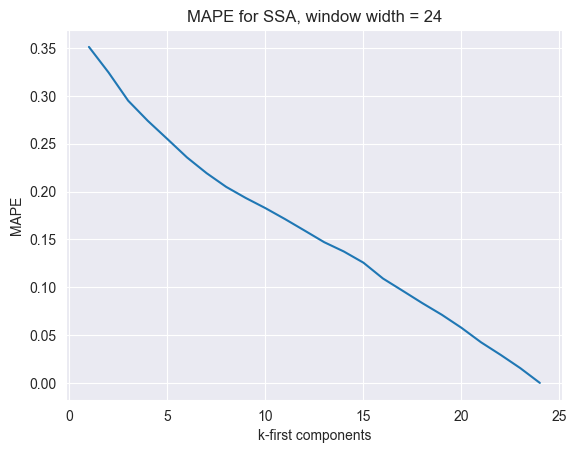

In [14]:
sns.lineplot(x=np.arange(1, window_width + 1), y=metrics_ssa['MAPE'])
plt.ylabel('MAPE')
plt.xlabel('k-first components')
plt.title('MAPE for SSA, window width = 24')
plt.show()

In [15]:
def hankel(x, window_size):
    return np.array([x[i:i+window_size] for i in range(0, len(x) - window_size + 1)])

def unhankel(x):
    dims_left = list(x.shape[2:])
    shape = [x.shape[0] + x.shape[1] - 1] + dims_left

    sums = np.zeros(shape)

    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            sums[i+j] += x[i,j]

    for i in range(len(sums)):
        d = min([i + 1, x.shape[0], x.shape[1], len(sums) - i])
        sums[i] /= d

    return sums

def windowed_transform(x, window_size):
    res = []
    delta = len(x) - len(x) // window_size * window_size
    for i in range(delta, len(x), window_size):
        res.append(x[i:i+window_size])
    return np.array(res)

def windowed_inverse_transform(x):
    x = np.array(x)
    shape = x.shape

    res = np.zeros(shape=(shape[0] * x.shape[1], *shape[2:]))
    for i in range(x.shape[0]):
        res[i*x.shape[1]:(i+1)*x.shape[1]] = x[i, :]
    return res

In [16]:
class TransformHankel:
    def __init__(self, window_size):
        self.window_size = window_size
    
    def transform(self, x):
        return hankel(x, self.window_size)
    
    def inverse(self, x):
        return unhankel(x)


class TransformWindowed:
    def __init__(self, window_size):
        self.window_size = window_size
    
    def transform(self, x):
        return windowed_transform(x, self.window_size)
    
    def inverse(self, x):
        return windowed_inverse_transform(x)


class TransofrmSwapDims:
    def __init__(self, i, j):
        self.i = i
        self.j = j
    
    def transform(self, x):
        return np.swapaxes(x, self.i, self.j)

    def inverse(self, x):
        return np.swapaxes(x, self.j, self.i)

In [17]:
class TransformStack:
    def __init__(self, transforms):
        self.transforms = transforms
    
    def transform(self, x):
        for transform in self.transforms:
            x = transform.transform(x)
        return x
    
    def inverse(self, x):
        for transform in reversed(self.transforms):
            x = transform.inverse(x)
        return x

In [18]:
x.shape

(2382,)

In [19]:
window_width = hankelization_window_width

transform = TransformStack([
    TransformWindowed(24),
    TransformHankel(1)
])

hankel_x = transform.transform(x)
hankel_x.shape

(99, 1, 24)

In [20]:
def optimize_first_k(x, parafac_result, transform):
    cur_weights = np.zeros_like(parafac_result.weights)
    opt_order = []

    for k in range(len(parafac_result.weights)):
        opt_i = None
        opt_mape = None

        for i in range(len(cur_weights)):
            if cur_weights[i] == 1:
                continue

            cur_weights[i] = 1
            parafac_result.weights = cur_weights

            px = tl.cp_to_tensor(parafac_result)

            restored_x = transform.inverse(px)

            comp_x = x
            if len(x) > len(restored_x):
                delta = len(x) - len(restored_x)
                comp_x = comp_x[delta:]
            mape = MAPE(comp_x, restored_x)

            if opt_mape is None or mape < opt_mape:
                opt_mape = mape
                opt_i = i
            
            cur_weights[i] = 0
        
        cur_weights[opt_i] = 1
        opt_order.append(opt_i)

    for i in range(len(parafac_result.factors)):
        parafac_result.factors[i] = parafac_result.factors[i][:, opt_order]

    return opt_order

In [21]:
parafac_rank = parafac_rank
parafac_x = tl.decomposition.parafac(
    hankel_x,
    rank=parafac_rank,

    n_iter_max=1000,
    tol=1e-1,

    verbose=False
)
_ = optimize_first_k(x, parafac_x, transform)

In [22]:
metricts_parafac = {
    'MSE': [],
    'MAPE': []
}

for i in range(1, parafac_rank):
    weights = np.zeros(parafac_rank)
    weights[:i] = 1
    parafac_x.weights = weights

    px = tl.cp_to_tensor(parafac_x)

    restored_x = windowed_inverse_transform(unhankel(px))

    comp_x = x
    if len(x) != len(restored_x):
        delta = len(x) - len(restored_x)
        comp_x = comp_x[delta:]

    mse = MSE(comp_x, restored_x)
    mape = MAPE(comp_x, restored_x)

    metricts_parafac['MSE'].append(mse)
    metricts_parafac['MAPE'].append(mape)

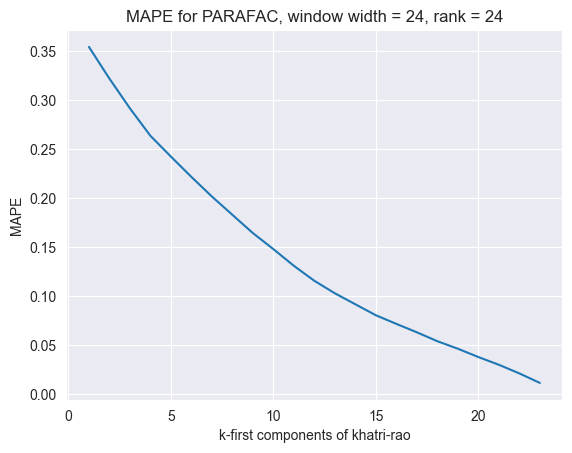

In [23]:
sns.lineplot(x=np.arange(1, parafac_rank), y=metricts_parafac['MAPE'])
plt.ylabel('MAPE')
plt.xlabel('k-first components of khatri-rao')
plt.title('MAPE for PARAFAC, window width = 24, rank = 24')
plt.show()

Сравним полученные графики

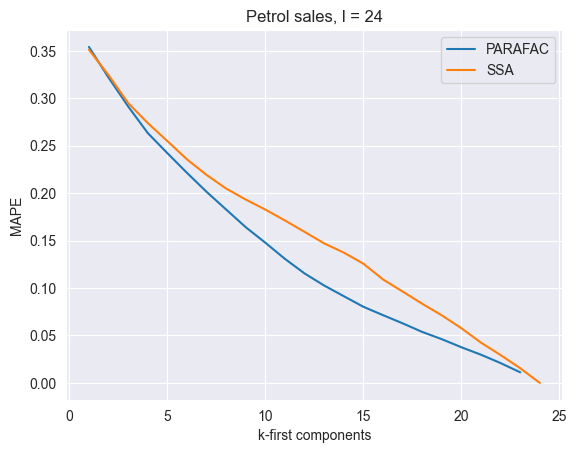

In [26]:
sns.lineplot(x=np.arange(1, parafac_rank), y=metricts_parafac['MAPE'], label='PARAFAC')
sns.lineplot(x=np.arange(1, window_width + 1), y=metrics_ssa['MAPE'], label='SSA')
plt.ylabel('MAPE')
plt.xlabel('k-first components')
plt.title('Petrol sales, l = 24')
plt.show()

In [25]:
x.shape

(2382,)